# Proglearn: Scene Segmentation
*Neuro Data Design II: Spring 2022*


This tutorial provides a walkthrough to applying a Random Forest model to perform scene segmentation on images taken from the International Skin Imaging Collaboration (ISIC) dataset from 2016 using Scikit-Image. 


**Contributor**: Amy van Ee (avanee1@jhu.edu)

# I. Preprocessing of Images

In this first section, we will import our images from the ISIC dataset and familiarize ourselves with this dataset.

In [18]:
#========================================================#
# retrieve data

import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# location of data
dataloc = 'C:/Users/Amy/Documents/Python/Neuro Data Design/'

# extract images
datalbl = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/'
dataimg = dataloc + 'NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/'

lblpaths = [datalbl+im for im in os.listdir(datalbl)]
imgpaths = [dataimg+im for im in os.listdir(dataimg)]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print('Total # of images =', len(imgpaths))
print('Total # of labels =', len(lblpaths))

Total # of images = 1279
Total # of labels = 1279


**Visualize an Example Image**

We will choose a sample image from the ISIC dataset to see the original image adjacent to the annotated image.

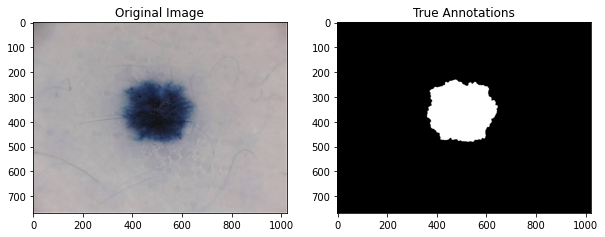

In [12]:
#========================================================#
# Plot the original image alongside the annotated image

# Prepare plot
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,10)

# import image 1
image = cv2.imread(imgpaths[1])
# import annotation for image 1 and convert to greyscale 
label_grey = (rgb2gray(cv2.imread(lblpaths[1]) ) * 1000).astype(int)

# plot data
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(label_grey, cmap = plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

**Dimensions of Images**

We will next take a look at the dimensions of our images to gain a better understanding of our dataset.

C:\Users\Amy\AppData\Local\Temp\ipykernel_25496\124859513.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])


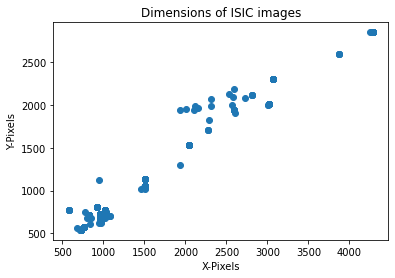

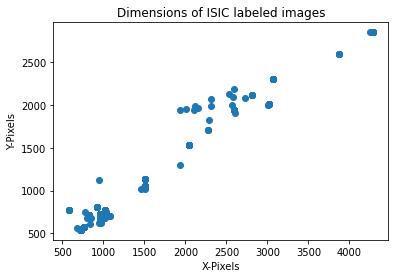

In [19]:
#========================================================#
# Look at dimensions of images in the dataset

# load all images
images = [cv2.imread(img) for img in imgpaths]
labels_grey = np.array([(rgb2gray(cv2.imread(lblpath))*1000).astype(int) for lblpath in lblpaths])

# get dimensions of dataset
xdim_images = [np.shape(img)[1] for img in images]
ydim_images = [np.shape(img)[0] for img in images]

xdim_labels = [np.shape(lbl)[1] for lbl in labels_grey]
ydim_labels = [np.shape(lbl)[0] for lbl in labels_grey]

# make a plot
plt.scatter(xdim_images, ydim_images)
plt.title("Dimensions of ISIC images")
plt.xlabel("X-Pixels")
plt.ylabel("Y-Pixels")
plt.show()

# make a plot
plt.scatter(xdim_labels, ydim_labels)
plt.title("Dimensions of ISIC labeled images")
plt.xlabel("X-Pixels")
plt.ylabel("Y-Pixels")
plt.show()

# II. Scene Segmentation using Scikit

Having familiarized ourself with the images after some analysis, we will now proceed to perform scene segmentation.

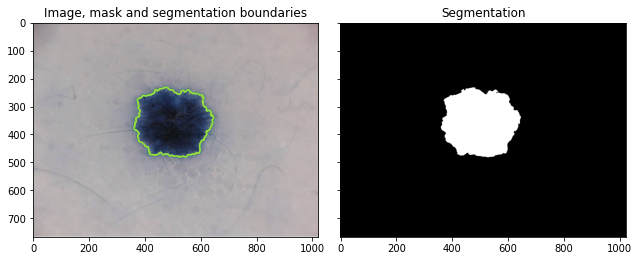

In [16]:
# ========================================================#
# Use scikit-image to perform Image Segmentation

# import packages specific to scene segmentation
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

# prepare training labels to train the model
training_labels = np.zeros(image.shape[:2], dtype=np.uint8)
training_labels = np.add(label_grey, training_labels) 
training_labels[training_labels == 0] = 1 

# perform training 
sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True, 
    edges=False, 
    texture=True,
    sigma_min=sigma_min, 
    sigma_max=sigma_max,
    channel_axis=-1
)

# obtain features from image
features = features_func(image)

# define random forest
clf = RandomForestClassifier(
    n_estimators=50, 
    n_jobs=-1,
    max_depth=10, 
    max_samples=0.05
)

# fit forest to features from original image and labeled image
clf = future.fit_segmenter(training_labels, features, clf)

# predict labels after training
# result will be array of 1's (normal) and 1000's (lesion)
result = future.predict_segmenter(features, clf)

# plot results
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(image, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(result, cmap = plt.cm.gray)
ax[1].set_title('Segmentation')
fig.tight_layout()

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation and the true annotated image.

Adapted Rand error: 0.01019900105317395
Adapted Rand precision: 0.9798079367678226
Adapted Rand recall: 1.0
False Splits: 0.014703142214246505
False Merges: 0.014380736350939949
Dice Coefficient: 0.9985239974791867


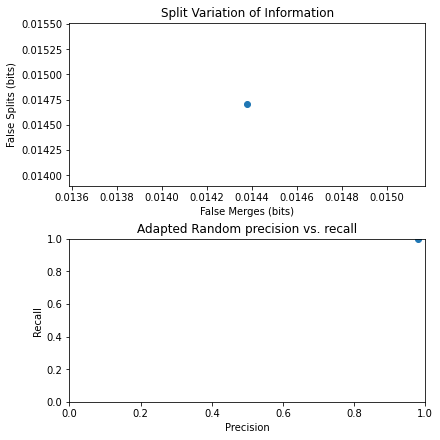

In [17]:
#========================================================#
# Analyze the accuracy by looking at 
# precision, recall, false splits, false merges, dice score

# import the necessary package
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

# calculate the dice coefficient
def get_dice(true, test):
    return np.size(test[test == true]) * 2.0 / (np.size(true) + np.size(test))

# correction so that the "normal" label for the predicted 
# array matches that of the true array (both "0")
result[result == 1] = 0 

# calculate error, precision, recall, splits, merges, dice
error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)

# print results
print(f'Adapted Rand error: {error}')
print(f'Adapted Rand precision: {precision}')
print(f'Adapted Rand recall: {recall}')
print(f'False Splits: {splits}')
print(f'False Merges: {merges}')
print(f'Dice Coefficient: {dice}')

# create figure to show results
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges and splits
ax[0].scatter(merges, splits)
ax[0].set_xlabel('False Merges (bits)')
ax[0].set_ylabel('False Splits (bits)')
ax[0].set_title('Split Variation of Information')

# plot preicision and recall
ax[1].scatter(precision, recall)
ax[1].set_xlabel('Precision')
ax[1].set_ylabel('Recall')
ax[1].set_title('Adapted Random precision vs. recall')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

plt.show()

Evidently, it appears that scikit-image did a good job of scene segmentation, and so we next test it on other images in the dataset.

**Testing the Model**

We will now predict the scene segmentation for a few other images.

In [40]:
# ========================================================#
# define a function to perform scene segmentation using 
# the trained classifier (clf)

def sceneseg(img, lbl):
    # get features
    features = features_func(img)
    pred = future.predict_segmenter(features, clf)

    # correction so that the "normal" label for the predicted 
    # array matches that of the true array (both "0")
    pred[pred == 1] = 0 

    ### QUANTIFICATION ###

    # calculate error, precision, recall, splits, merges, dice
    error, precision, recall = adapted_rand_error(lbl, pred)
    splits, merges = variation_of_information(lbl, pred)
    dice = get_dice(lbl, pred)

    # print results
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"False Splits: {splits}")
    print(f"False Merges: {merges}")
    print(f"Dice Coefficient: {dice}")

    ### VISUALIZATION ###

    # plot
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 6))

    ax[0].imshow(segmentation.mark_boundaries(img, pred, mode='thick'))
    ax[0].set_title('Image')
    ax[1].imshow(lbl, cmap = plt.cm.gray)
    ax[1].set_title('True Annotation')
    ax[2].imshow(pred, cmap = plt.cm.gray)
    ax[2].set_title('Segmentation')
    fig.tight_layout()

    plt.show()

Adapted Rand error: 0.32522165249230506
Adapted Rand precision: 0.5091814989882328
Adapted Rand recall: 1.0
False Splits: 0.5449873773487167
False Merges: 0.6725479979631201
Dice Coefficient: 0.8226666530590375


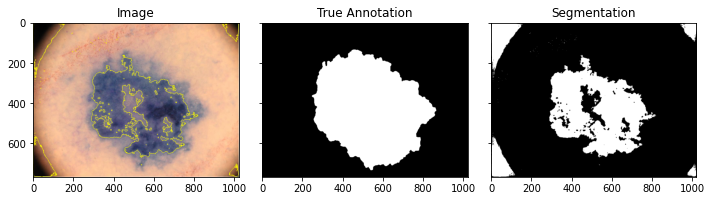

In [48]:
# ========================================================#
# perform scene segmentation on a third image

sceneseg(images[2], labels_grey[2])

Adapted Rand error: 0.3137226021913677
Adapted Rand precision: 0.5223914064231524
Adapted Rand recall: 1.0
False Splits: 0.3217675969503671
False Merges: 0.5144239114641048
Dice Coefficient: 0.8688960215544845


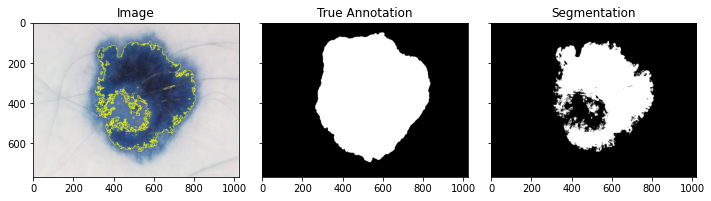

In [46]:
# ========================================================#
# perform scene segmentation on a third image

sceneseg(images[3], labels_grey[3])

Adapted Rand error: 0.3114991776965962
Adapted Rand precision: 0.5249723629355431
Adapted Rand recall: 1.0
False Splits: 0.3240013624982853
False Merges: 0.478223882652676
Dice Coefficient: 0.8970408509530868


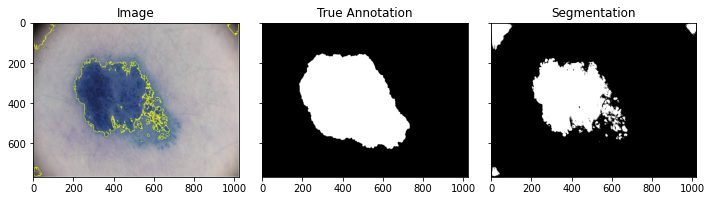

In [47]:
# ========================================================#
# perform scene segmentation on a third image

sceneseg(images[8], labels_grey[8])

**Conclusion**

Evidently, we can see that Scikit-Image works well to perform scene-segmentation of images.